along-track SSH (SLA, ADT) measurements

- parse tracks, interpolate to regular grid (for each satellite)
- call arrays and apply spatial / temporal filtering (to either ADT, SLA, or U_g) 
- export processed and/or filtered fields to personal machine to carry out more memory heavy tasks 
- tasks on my machine = seasonality of EKE, 2d spectra 

In [1]:
import numpy as np
import xarray as xr 
import time 
import pickle 
import scipy.ndimage as si
from scipy import interpolate
from scipy import integrate
from intake import open_catalog
from datetime import datetime
from tqdm.notebook import tqdm
from altimetry_tools import Filter, smooth_tracks, specsharp
from altimetry_tools import smooth_tracks_deg, smooth_tracks_Ld
from altimetry_tools import velocity
# plotting 
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# -- main PARAMETERS --- 
this_sat = 'j2'              # mission to consider 
# hor_grid_spacing = 10      # (now defined below) km, grid to which to interpolate tracks
# interp_cutoff = 5            # number of acceptable nan gaps in grid cell units across which to interpolate
coarsening_factor0 = 7       # (*hor_grid_spacing = coarsened grid size) this factor should be multiplied by hor_grid_spacing 
nyquist_wavelength = np.pi   # factor relative to coarsening factor (what scales do we want to resolve...pi times the grid scale)
f_type = 'sharp'             # filter type (gaussian or sharp)
# -----------------------
# -- coastline file 
x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/misc/coastlines_global.nc')  
# -- deformation radius 
# Chelton et al. 1998 'global variability of the first baroclinic rossby radius of deformation'
c98 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/misc/global_deformation_radius_chelton_1998.nc')  
c98 = c98['values'].data
# (http://www-po.coas.oregonstate.edu/research/po/research/rossby_radius/index.html#anchor2)  (w/ Ld in km)
# -- catalog of available satellites 
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")# load individual satellite 
# ['al', 'alg', 'c2', 'e1', 'e1g', 'e2', 'en', 'enn', 'g2', 'h2', 'j1', 'j1g', 'j1n', 'j2', 'j2g', 'j2n', 'j3', 's3a', 's3b', 'tp', 'tpn']

# -- lat/lon boundaries (permits subsetting to speed processing time)
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65

In [2]:
# ------------------------------------------------------------------------------------------------
# -- LOAD -- parsed data (gridded and interpolated in time) -- from initial_processing.ipynb
# load file created by initial_processing (data have been spatially and temporally gridded and desired nans interpolated)
load_sat = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks_adt_x20.p', 'rb'))
load_sat2 = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks_adt_x20_interp_t.p', 'rb'))
lon_t = load_sat['lon_t']
lat_t = load_sat['lat_t']
track_t = load_sat['track_t']
adt = load_sat2['adt']  
# sla = load_sat['sla']
dist = load_sat['dist']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
time_record = load_sat['time_record']
track_record = load_sat['track_record']
hor_grid_spacing = dist[1][20] - dist[1][19]
# ------------------------------------------------------------------------------------------------

In [3]:
# time index check (what fraction of year or how many years do we want to consider...saves computational time)
# ******************************************
time_cutoff = len(time_record[0]) - 165 # 54  (j2 = 129, 20, 165)
# ******************************************
repeat_time = (time_record[0][1] - time_record[0][0])/(60*60*24)
print('repeat time = ' + str(np.round(repeat_time,2)) + ' days')
year_frac = ((time_record[0][0:time_cutoff] - time_record[0][0])/(60*60*24))/365
print('length of time series = ' + str(np.round(year_frac[-1], 2)) + ' years, = ' + str(len(year_frac)) + ' values')

# SUBSET BY TIME (subset each track by desired time indices to speed up computation time) 
subset = 1 # (yes/no)
if subset:
    sub_time_ind = range(0, time_cutoff)  # (j3=38) (s3a = 20)
    adt_t_win = []
    sla_t_win = []
    time_t_win = []
    for i in tqdm(range(len(track_record))):
        adt_t_win.append(adt[i][sub_time_ind, :])
        # -- because I principally care about ADT --> geostrophic velocity, I do not save SLA...compute it here from shorter time mean of ADT
        sla_t_win.append(adt[i][sub_time_ind, :] - np.nanmean(adt[i][sub_time_ind, :], axis=0))
        # -- if sla is saved in above file 
        # sla_t_win.append(sla[i][sub_time_ind, :])
        time_t_win.append(time_record[i][sub_time_ind])
else:
    adt_t_win = adt_time
    sla_t_win = []
    for i in range(len(track_record)):
        sla_t_win.append(adt[i] - np.nanmean(adt[i], axis=0))
    time_t_win = time_record
    
# SLA SQUARE
sla_sq = []
adt_sq = []
for i in tqdm(range(len(sla_t_win))):
    sla_sq.append(sla_t_win[i]**2)
    adt_sq.append(adt_t_win[i]**2)

repeat time = 9.92 days
length of time series = 3.04 years, = 113 values


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

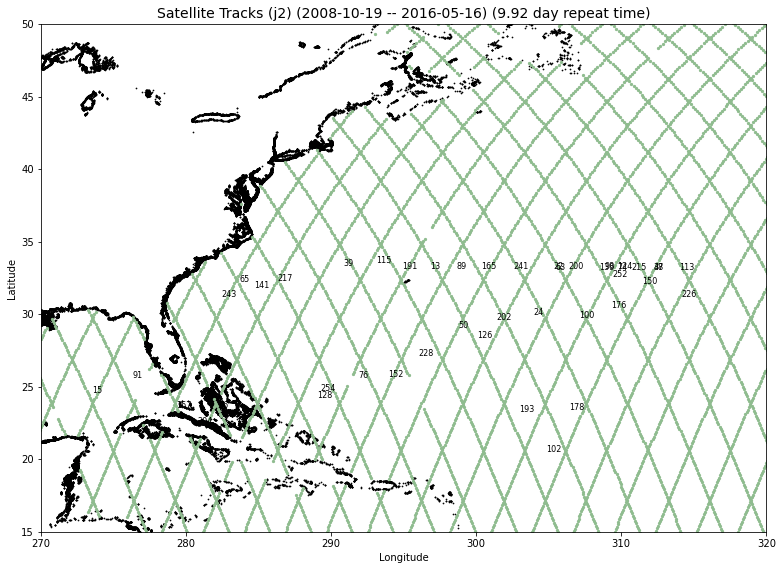

In [5]:
# FIGURE - Satellite Tracks and ID (refence when selecting single track)
t_i = np.array([2])                                   # TRACK NO: s3a: 33 # en: 3 # J2: 24,33,124,176,200 # TP: 13,15,23 # AL: 2,549 # G2: 61,471
pass_index = 5                                        # cycle number 
save_f = 0                                            # save figure toggle 
good_indi_dist = np.where(track_record == t_i)[0][0]  # index of desired track 
zoom_view = 1                                         # toggle to select smaller domain in with clearer track numbers 
if zoom_view: 
    z_lon_w = 270
    z_lon_e = 320
    z_lat_s = 15
    z_lat_n = 50
    inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
    # tracks that fall within this box 
    [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
# PLOT     
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.scatter(x4['lon'].values, x4['lat'].values, s=0.5, color='k')
if zoom_view:
    for i in range(len(ai)):
        ax.scatter(lon_record[ai[i]], lat_record[ai[i]], s=5, color='#8FBC8F')
        ax.text(np.nanmedian(lon_record[ai[i]][(lon_record[ai[i]] > z_lon_w) & (lon_record[ai[i]] < z_lon_e)]), \
                np.nanmedian(lat_record[ai[i]][(lat_record[ai[i]] > z_lat_s) & (lat_record[ai[i]] < z_lat_n)]), \
                str(np.int(track_record[ai[i]])), fontsize=8)    
else:
    for i in range(len(lon_record)):
        ax.scatter(lon_record[i], lat_record[i], s=0.01, color='#8FBC8F')

ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=4, color='#FFD700')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Satellite Tracks (' + this_sat + ')' + ' (' + str(datetime.utcfromtimestamp(time_record[0][0]))[0:10] + \
             ' -- ' + str(datetime.utcfromtimestamp(time_record[0][-1]))[0:10] + ') (' + str(np.round(repeat_time,2)) + ' day repeat time)', fontsize=14)
if zoom_view:
    ax.set_xlim([z_lon_w, z_lon_e])
    ax.set_ylim([z_lat_s, z_lat_n])
else:
    ax.set_xlim([lon_w, lon_e])
    ax.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(np.nanmean([lat_s, lat_n])))
ax.set_aspect(w)
plt.show()
if save_f:
    f.savefig(this_sat + '_track_map_global', dpi=250)

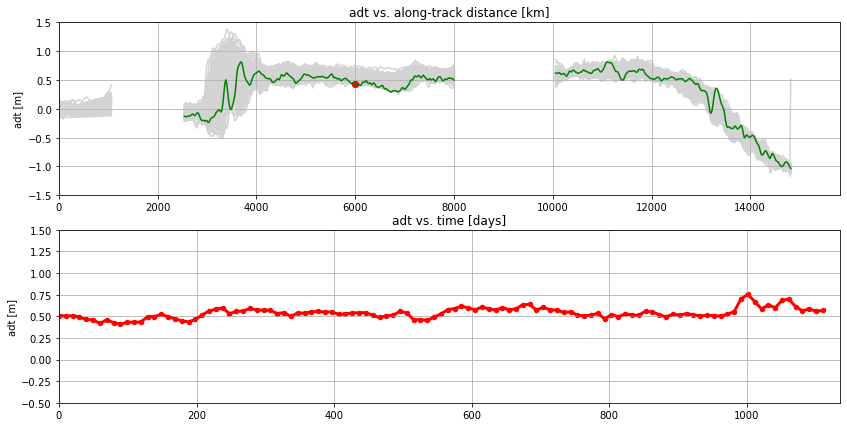

In [4]:
# FIGURE: sample ADT along a single track w/ temporal variability 
t_i = np.array([24])   # TRACK NO: s3a: 33 # en: 3 # J2: 24,33,124,176,200 # TP: 13,15,23 # AL: 2,549 # G2: 61,471
pass_x = 300           # along-track location to consider time series 
pass_x_2 = 500         # along-track location to consider time series
pass_t = 10             # cycle number 
xmax = 18000           # plot, horizontal axis limit 
gid = np.where(track_record == t_i)[0][0]
# PLOT 
f, (ax2, ax1) = plt.subplots(2,1,figsize=(14,7))
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], linewidth=3, color='r')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], s=20, color='r')
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], linewidth=3, color='b')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], s=20, color='b')
# t_fit = np.polyfit((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], 1)
ax1.set_title('adt vs. time [days]')
ax1.set_ylabel('adt [m]')
ax1.set_ylim([-0.5, 1.5])
ax1.set_xlim([0, (time_t_win[gid][-1] - time_t_win[gid][0])/(60*60*24) + 25])

for i in range(np.shape(sla_t_win[gid])[0]):
    # ax2.plot(dist[gid], sla_t_win[gid][i, :], color='#D3D3D3', zorder=1)
    ax2.plot(dist[gid], adt_t_win[gid][i, :], color='#D3D3D3', zorder=1)
ax2.plot(dist[gid], adt_t_win[gid][pass_t, :], color='g', zorder=2)
# ax2.plot(dist[gid], sla_t_win[gid][pass_t, :], color='g', zorder=2)
ax2.scatter(dist[gid][pass_x], adt_t_win[gid][pass_t, pass_x], color='r', s=40, zorder=2)
ax2.scatter(dist[gid][pass_x_2], adt_t_win[gid][pass_t, pass_x_2], color='b', s=40, zorder=2)
ax2.set_title('adt vs. along-track distance [km]')
ax2.set_xlim([0, np.nanmax(dist[gid]) + 1000])
ax2.set_ylabel('adt [m]')
ax2.set_ylim([-1.5, 1.5])
ax1.grid()
ax2.grid()
plt.show()
# f.savefig(this_sat + '_sample_adt_space_time', dpi=250)

In [14]:
# INITIALIZE LAPLACIAN/BIHARMONIC FILTER 
filter_type = 'Taper'
plot_filter = 1            # show filter relative to target w/ error 
N = 35                     # filter steps (computational choice)
dx = 1
LfB = coarsening_factor0     # boxcar (full width of filter) 
LfT = coarsening_factor0/2   # sharp
LfG = LfB/np.sqrt(6)         # gaussian 

In [8]:
# APPLY to SLA  
# %time sla_filt = Filter(N, filter_type, sla_t_win, dx, LfT, plot_filter=1) # optional: plot_filter=1
# %time sla_sq_filt = Filter(N, filter_type, sla_sq, dx, LfT, plot_filter=1)

In [12]:
# OLD 
# -- SMOOTH (the A SINGLE iteration, not applicable if smoothing at multiple scales)
# -- CREATES & USES FILTER KERNEL (slower method)
# filter_kernel, jj = specsharp(hor_grid_spacing, coarsening_factor0, nyquist_wavelength)
# space_time = 0  # smooth across space or time (0=space)
# sla_smooth = smooth_tracks(dist, sla_t_win, track_record, coarsening_factor0, f_type, filter_kernel, nyquist_wavelength, space_time)
# sla_sq_smooth = smooth_tracks(dist, sla_sq, track_record, coarsening_factor0, f_type, filter_kernel, nyquist_wavelength, space_time)
# -- COARSEN (reduce horizontal resolution)
# dist_coarse, lon_coarse, lat_coarse, sla_coarse = coarsen(dist, lon_record, lat_record, coarsening_factor0, sla_smooth)

In [11]:
# -- deformation radius --  filter (this is slow)
%time sla_filtered_Ld = smooth_tracks_Ld(dist, sla_t_win, lon_record, lat_record, hor_grid_spacing, c98)


CPU times: user 13min 50s, sys: 356 ms, total: 13min 51s
Wall time: 13min 51s


In [15]:
# -- fixed degree -- filtering function (filter varies in width with local dx equal to fixed delta longitude)
resolution = 0.1  # (1/10 degree ... first interpolate gridded data locally to a grid of this local resolution)
sigma = coarsening_factor0  # (~ effective filter of 8/10 degree (8/10 = +/- 1 std deviation of gaussian))
%time sla_filtered_deg = smooth_tracks_deg(dist, sla_t_win, lon_record, lat_record, resolution, sigma)


CPU times: user 4.25 s, sys: 27.7 ms, total: 4.28 s
Wall time: 4.27 s


In [47]:
# DEFINE SET OF FILTERING LENGTHS to iteratively filter to... to be ~ equispaced in wavenumber space 
dx = hor_grid_spacing
L = 275                                          # = number of grid points contributing to each spectral estimate
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))
# inn = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
inn = [8,10,13,16,20,28,36]
k_sub = k[inn]
coarsening_factors = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone = np.int(np.floor( (1/k_sub[i])/hor_grid_spacing ))
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    # exec(f'coarse_fac_{i} = {thisone}')
    coarsening_factors[i] = thisone
print(coarsening_factors)

smoothing to 340 km
smoothing to 270 km
smoothing to 200 km
smoothing to 170 km
smoothing to 130 km
smoothing to 90 km
smoothing to 70 km
[34. 27. 20. 17. 13.  9.  7.]


In [5]:
# VELOCITY
# VELOCITY 
# VELOCITY (call function, input either adt or sla) 
stencil_width = 3 # units of grid step (from arbic = 3,5,7)
eta_grad, total_vel, total_vel_f = velocity(dist, adt_t_win, lon_record, lat_record, track_record, stencil_width)
# eta_grad2, total_vel2, total_vel_f = velocity(dist, adt_t_win, lon_record, lat_record, track_record, 3)  # example for different stencil
# VELOCITY SQUARE
total_vel_sq = []
for i in tqdm(range(len(total_vel))):
    total_vel_sq.append(total_vel[i]**2)
# if want to free up some memory 
del eta_grad

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

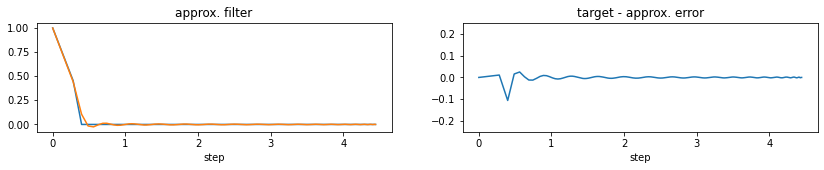

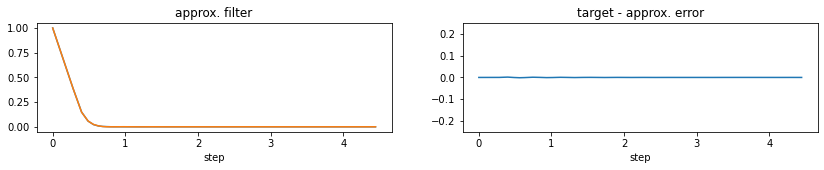

In [4]:
# SLA FILTERING EXAMPLE 
# re-INITIALIZE filter scales for example below
plot_filter = 1              # show filter relative to target w/ error 
N = 35                       # NO LONGER NEEDED filter steps (computational choice)
dx = 1
LfB = 2                      # boxcar (full width of filter) 
LfT = LfB/2                  # sharp
LfG = LfB/np.sqrt(6)         # gaussian 

sla_taper = Filter(N, 'Taper', sla_t_win, dx, LfT, plot_filter=1)
# sla_sq_taper = Filter(N, 'Taper', plot_filter, total_vel_sq, hor_grid_spacing, coarsening_factor0*2)
sla_gauss = Filter(N, 'Gaussian', sla_t_win, dx, LfG, plot_filter=1)
# sla_sq_gauss = Filter(N, 'Gaussian', plot_filter, total_vel_sq, hor_grid_spacing, coarsening_factor0*2)
sla_boxcar = Filter(N, 'boxcar', sla_t_win, dx, LfB, plot_filter=1)
# sla_sq_boxcar = smooth_tracks_boxcar(dist, total_vel_sq, coarsening_factor0*2)

Using default N, N = 23 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 23 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.


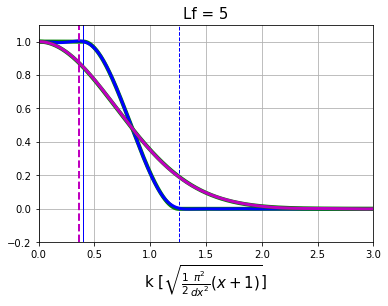

In [7]:
# VELOCITY FILTERING EXAMPLE 
sample_LfB = 5                            # boxcar (full width of filter) 
sample_LfT = sample_LfB                    # sharp
sample_LfG = sample_LfB                    # gaussian 
N = 35                                     # NO LONGER NEEDED
plot_filter = 1 
vel_taper = Filter(N, 'Taper', total_vel, 1, sample_LfT, plot_filter=1)
vel_sq_taper = Filter(N, 'Taper', total_vel_sq, 1, sample_LfT)
vel_gauss = Filter(N, 'Gaussian', total_vel, 1, sample_LfG, plot_filter=1)
vel_sq_gauss = Filter(N, 'Gaussian', total_vel_sq, 1, sample_LfG)
vel_boxcar = Filter(N, 'boxcar', total_vel, 1, sample_LfB)
vel_sq_boxcar = Filter(N, 'boxcar', total_vel_sq, 1, sample_LfB)

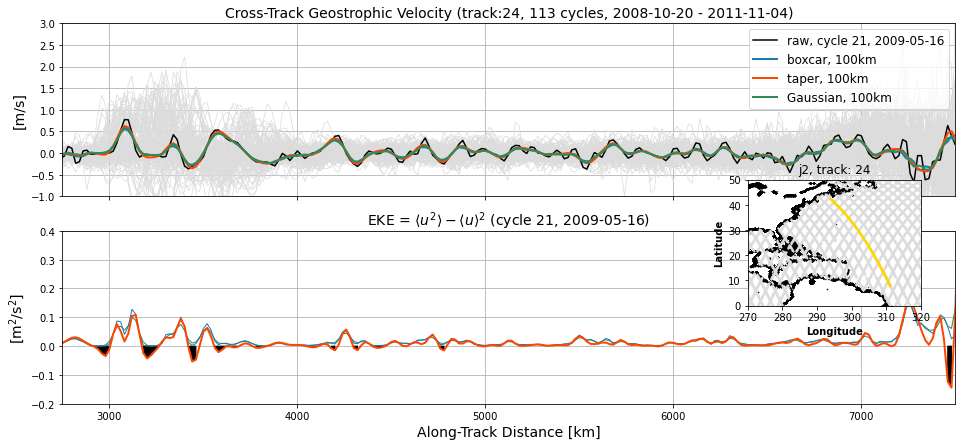

In [21]:
# FILTER COMPARISONS USING CROSS TERM
pi = 21
f, (ax0, ax1) = plt.subplots(2,1,figsize=(16,7), sharex=True)
for i in range(np.shape(total_vel[gid])[0]):
    ax0.plot(dist[gid], total_vel[gid][i, :], color='#DCDCDC', linewidth=0.75)                                         # all vel
ax0.plot(dist[gid], total_vel[gid][pi, :], color='k', linewidth=1.5, \
         label='raw, cycle ' + str(pi) + ', ' + str(datetime.utcfromtimestamp(time_record[gid][pi]))[0:10])                                        # raw 
ax0.plot(dist[gid], vel_boxcar[gid][pi, :], label='boxcar, ' + str(np.int(sample_LfB*hor_grid_spacing)) + 'km', linewidth=2)                      # boxcar 
ax0.plot(dist[gid], vel_taper[gid][pi, :], label='taper, ' + str(np.int(sample_LfB*hor_grid_spacing)) + 'km', color='#FF4500', linewidth=2)                 # sharp filter (lap/bi)
ax0.plot(dist[gid], vel_gauss[gid][pi, :], label='Gaussian, ' + str(np.int(sample_LfB*hor_grid_spacing)) + 'km', color='#2E8B57', linewidth=2)     # Gaussian 
ax0.set_title('Cross-Track Geostrophic Velocity (track:' + str(t_i[0]) + \
              ', ' + str(np.shape(total_vel[gid])[0]) + ' cycles, ' + \
              str(datetime.utcfromtimestamp(time_t_win[gid][0]))[0:10] + ' - ' + \
              str(datetime.utcfromtimestamp(time_t_win[gid][-1]))[0:10]+ ')', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=12, loc='upper right')
ax0.set_ylabel('[m/s]', fontsize=14)
ax0.set_ylim([-1, 3])
ax0.grid()

# for i in range(np.shape(total_vel[gid])[0]):
#     ax1.plot(dist[gid], vel_sq_taper[gid][i, :] - vel_taper[gid][i, :]**2, color='#dfd0ca')
ax1.plot(dist[gid], vel_sq_gauss[gid][pi, :] - vel_gauss[gid][pi, :]**2, color='#2E8B57', linewidth=1)
ax1.plot(dist[gid], vel_sq_boxcar[gid][pi, :] - vel_boxcar[gid][pi, :]**2, linewidth=1)
ax1.plot(dist[gid], vel_sq_taper[gid][pi, :] - vel_taper[gid][pi, :]**2, color='#FF4500', linewidth=2)  # (total_vel[gid][pi, :]**2)
# yyy = vel_sq_taper[gid][pi, :] - vel_taper[gid][pi, :]**2
yyy = vel_sq_taper[gid][pi, :] - vel_taper[gid][pi, :]**2
neg_eke = np.where(yyy < -0.001)[0]
ax1.fill_between(dist[gid], yyy, where=yyy<0, zorder=2, color='k')
ax1.set_title(r'EKE = $\langle u^2 \rangle - \langle u \rangle^2$ (cycle ' + \
              str(pi) + ', ' + str(datetime.utcfromtimestamp(time_t_win[gid][pi]))[0:10] + ')', fontsize=14) 
ax1.set_ylabel('[m$^2$/s$^2$]', fontsize=14)
ax1.set_xlabel('Along-Track Distance [km]', fontsize=14)
ax1.set_xlim([2750, 7500])
ax1.set_ylim([-0.2, .4])

a = plt.axes([.72, .32, .15, .25]) # facecolor=c35q)
z_lon_w = 270
z_lon_e = 320
z_lat_s = 0
z_lat_n = 50
inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
a.scatter(x4['lon'].values, x4['lat'].values, s=0.1, color='k')
for i in range(len(ai)):
    a.scatter(lon_record[ai[i]], lat_record[ai[i]], s=1, color='#DCDCDC')
subset_in = np.where((dist[gid] > 2750) & (dist[gid] < 7000))[0]
a.scatter(lon_record[gid][subset_in], lat_record[gid][subset_in], s=1, color='#FFD700')
a.set_xlim([z_lon_w, z_lon_e])
a.set_ylim([z_lat_s, z_lat_n])
a.set_xlabel('Longitude', fontsize=10, fontweight='bold')
a.set_ylabel('Latitude', fontsize=10, fontweight='bold')
a.set_title(str(this_sat) + ', track: ' + str(t_i[0]), fontsize=12, alpha=1)

# taper_prime = np.nan*np.ones(np.shape(total_vel[gid]))
# gauss_prime = np.nan*np.ones(np.shape(total_vel[gid]))
# boxcar_prime = np.nan*np.ones(np.shape(total_vel[gid]))
# for i in range(np.shape(sla_t_win[gid])[0]):
#     taper_prime[i, :] = vel_taper[gid][i, :]*(total_vel[gid][i, :] - vel_taper[gid][i, :])
#     gauss_prime[i, :] = vel_gauss[gid][i, :]*(total_vel[gid][i, :] - vel_gauss[gid][i, :])
#     # boxcar_prime[i, :] = vel_boxcar[gid][i, :]*(total_vel[gid][i, :] - vel_boxcar[gid][i, :])
# ax.plot(dist[gid], np.abs(np.nanmean(boxcar_prime, axis=0)), label='boxcar')
# ax.plot(dist[gid], np.abs(np.nanmean(taper_prime, axis=0)), label='sharp', color='#FF4500')
# ax.plot(dist[gid], np.abs(np.nanmean(gauss_prime, axis=0)), label='Gaussian', color='#2E8B57')
# ax.set_ylim([0, .075])
# # ax.set_yscale('log')
# ax.set_xlim([2750, 7500])
# ax.set_ylabel('[m$^2$/s$^2$]', fontsize=14)
# ax.set_xlabel('Along-Track Distance [km]', fontsize=14)
# ax.set_title(r"Mean cross-term, $\langle u \rangle \left(u - \langle u \rangle \right)$, (" + str(np.shape(total_vel[gid])[0]) + " cycles)", fontsize=14)
# ax.grid()
ax1.grid()
ax1.plot()
f.savefig(this_sat + '_filter_comparison_lfb10', dpi=400)

In [7]:
aviso_at_ex = pickle.load(open(this_sat +'_aviso_interp_to_track_24_31mar2011.p', 'rb'))

In [8]:
aviso_at_ex.keys()

dict_keys(['aviso_u_at', 'aviso_v_at', 'at_dist', 'at_lon', 'at_lat'])

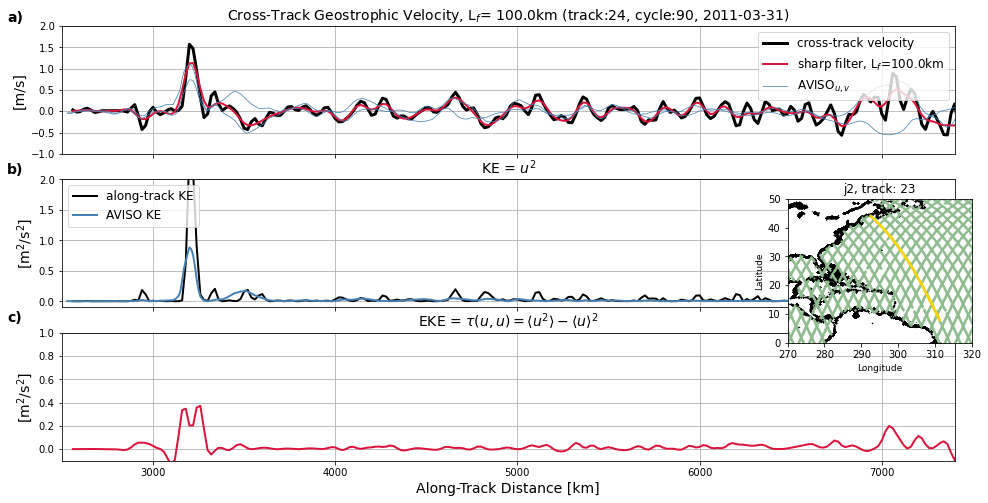

In [10]:
pass_index = 90
f, (ax0, ax, ax2) = plt.subplots(3,1,figsize=(16,8), sharex=True)
ax0.plot(dist[gid], total_vel[gid][pass_index, :], color='k', linewidth=3, label='cross-track velocity')                         # raw 
ax0.plot(dist[gid], vel_taper[gid][pass_index, :], label='sharp filter, L$_f$=' + str(sample_LfT*hor_grid_spacing) + 'km', \
         linewidth=2, color='#DC143C')  # sharp filter (lap/bi)
ax0.plot(aviso_at_ex['at_dist'], aviso_at_ex['aviso_u_at'], color='#4682B4', linewidth=0.75, label='AVISO$_{u,v}$')
ax0.plot(aviso_at_ex['at_dist'], aviso_at_ex['aviso_v_at'], color='#4682B4', linewidth=0.75)
ax0.set_title('Cross-Track Geostrophic Velocity, L$_f$= ' + str(sample_LfT*hor_grid_spacing) + \
              'km (track:' + str(t_i[0]) + ', cycle:' + str(pass_index) + ', ' + str(datetime.utcfromtimestamp(time_record[gid][90]))[0:10] + ')', \
              fontsize=14)
ax0.grid()
a = plt.axes([.755, .33, .16, .25]) # facecolor=c35q)
z_lon_w = 270
z_lon_e = 320
z_lat_s = 0
z_lat_n = 50
inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
a.scatter(x4['lon'].values, x4['lat'].values, s=0.1, color='k')
for i in range(len(ai)):
    a.scatter(lon_record[ai[i]], lat_record[ai[i]], s=1, color='#8FBC8F')
subset_in = np.where((dist[gid] > 2500) & (dist[gid] < 7000))[0]
a.scatter(lon_record[gid][subset_in], lat_record[gid][subset_in], s=1, color='#FFD700')
a.set_xlim([z_lon_w, z_lon_e])
a.set_ylim([z_lat_s, z_lat_n])
a.set_xlabel('Longitude', fontsize=9)
a.set_ylabel('Latitude', fontsize=9)
a.set_title(str(this_sat) + ', track: ' + str(gid), fontsize=12)
ax0.set_ylim([-1, 2])
ax0.set_ylabel('[m/s]', fontsize=14)

ax.plot(dist[gid], total_vel[gid][pass_index, :]**2, linewidth=2, color='k', label='along-track KE')
ax.plot(aviso_at_ex['at_dist'], 0.5*(aviso_at_ex['aviso_u_at']**2 + aviso_at_ex['aviso_v_at']**2), linewidth=2, label='AVISO KE', color='#4682B4')
ax.set_ylim([-.1, 2])
ax.set_ylabel('[m$^2$/s$^2$]', fontsize=14)
ax.set_title(r"KE = $u^2$", fontsize=14)

ax2.plot(dist[gid], vel_sq_taper[gid][pass_index, :] - vel_taper[gid][pass_index, :]**2, linewidth=2, color='#DC143C')
ax2.set_ylim([-.1, 1])
ax2.set_xlim([2500, 7400])
ax2.set_xlabel('Along-Track Distance [km]', fontsize=14)
ax2.set_title(r"EKE = $\tau(u,u) = \langle u^2 \rangle - \langle u \rangle^2$", fontsize=14)
ax2.set_ylabel('[m$^2$/s$^2$]', fontsize=14)
ax2.grid()

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=12, loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12, loc='upper left')
ax.grid()
ax0.text(2200, 2.1, 'a)', fontsize=14, fontweight='bold')
ax.text(2200, 2.1, 'b)', fontsize=14, fontweight='bold')
ax2.text(2200, 1.1, 'c)', fontsize=14, fontweight='bold')
plt.show()
f.savefig(this_sat + '_sample_vel_w_eke.jpg', dpi=400)

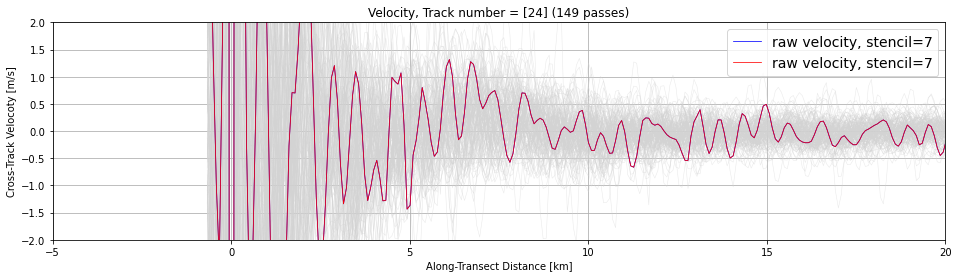

In [49]:
# FIGURE: compare different velocity estimations 
pass_index = 10
f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(total_vel[gid])[0]):
    ax.plot(lat_record[gid], total_vel[gid][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
for i in range(pass_index, pass_index + 1):
    # ax.plot(lat_record[gid], 50000*eta_grad[gid][i, :], linewidth=0.5, color='k', label=r'$\nabla$ADT')
    ax.plot(lat_record[gid], total_vel[gid][i, :], linewidth=0.75, color='b', label='raw velocity, stencil=7')
    ax.plot(lat_record[gid], total_vel_f[gid][i, :], linewidth=0.75, color='r', label='raw velocity, stencil=7')
    # ax.plot(lat_record[gid], total_vel2[gid][i, :], linewidth=0.75, color='r', label='raw velocity, stencil=3')
    # ax.plot(dist[0], vel_smooth_dict[10][good_indi_dist][i, :], linewidth=0.75, color='g', label='velocity smooth cf=' + str(coarsening_factors[10]))
ax.set_xlim([-5, 20])
ax.set_ylim([-2, 2])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Cross-Track Velocoty [m/s]')
ax.set_title('Velocity, Track number = ' + str(t_i) + ' (' + str(np.shape(adt_t_win[gid])[0]) + ' passes)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.grid()
plt.show()

In [54]:
# -- FILTER VELOCITY (loop over desired coarsening factors) (I do this in another file now)
vel_smooth_dict = []
vel_sq_smooth_dict = []
# space_time = 0
filter_type = 'Taper'
plot_filter = 0            # show filter relative to target w/ error 
N = 35                     # filter steps (computational choice)
for i in range(len(coarsening_factors)):
    vel_filt_i = Filter(N, filter_type, total_vel, 1, coarsening_factors[i])
    vel_sq_filt_i = Filter(N, filter_type, total_vel_sq, 1, coarsening_factors[i])
    
    # -- can coarsen if desired 
    # dist_coarse_30, lon_coarse_30, lat_coarse_30, sla_coarse_30 = coarsen(dist, lon_record, lat_record, coarse_fac_0, sla_smooth_30)
    vel_smooth_dict.append(vel_filt_i)
    vel_sq_smooth_dict.append(vel_sq_filt_i)

In [18]:
# -- FILTER in time 
# need to use kernel version of sharp filter 
coarsening_factors_time = np.array([1,4,6,8])  # [2,3,4,5,6,7,8]  # multiples of 10 day sampling period for jason 
nyquist_frequency = np.pi
space_time = 1  # 0 for space, 1 for time
# vel stored as list of tracks with each track having dimensions [cycle X distance]
vel_time_smooth_dict = []
for i in range(len(coarsening_factors_time)):
    #                                 smooth dim | data      | track num.  | coarsening factor  | filter | resolved scale
    vel_time_smooth_i = smooth_tracks(time_t_win, total_vel, track_record, coarsening_factors_time[i], 'gaussian', nyquist_frequency, space_time)
    vel_time_smooth_dict.append(vel_time_smooth_i)

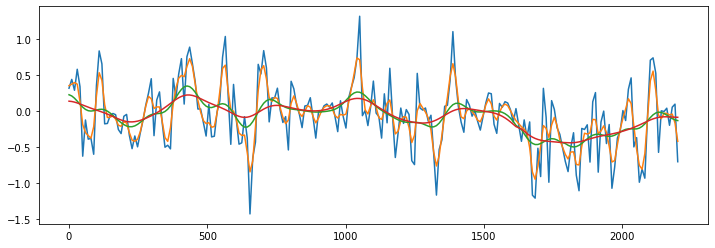

In [19]:
# Temporal filtering check 
pass_x = 350
t_i = np.array([24])  # s3a 33 # en 3 # J2 24,33,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
gid = np.where(track_record == t_i)[0][0]
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), total_vel[gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[0][gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[1][gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[2][gid][:, pass_x])
plt.show()

In [6]:
# clear more memory? 
# del adt_t_win
# ---------------   
# -- export to nc (for spectral analysis)
# ---------------
# variables = dist, sla, dist_coarse, sla_coarse, track_record 
# ---------------
save_p = 1
if save_p > 0:
# # SLA 
#     outputs = {'dist': dist, 'sla': sla_t_win, 
#                'sla_smooth_dict': sla_smooth_dict, \
#                'sla_sq_smooth_dict': sla_sq_smooth_dict, \
#                'lon_record': lon_record, 'lat_record': lat_record, \
#                'track': track_record, 'coarsening_factor_k': k_sub, \
#                'grid_spacing': hor_grid_spacing, 'time': time_t_win}
# VEL
    outputs = {'dist': dist, \
               'vel': total_vel, \
               # 'adt': adt_t_win, \
               # 'vel_smooth_dict': vel_smooth_dict, \
               # 'vel_sq_smooth_dict': vel_sq_smooth_dict, \
               'lon_record': lon_record, 'lat_record': lat_record, \
               'track': track_record, \
               'grid_spacing': hor_grid_spacing, \
               'time': time_t_win}
    
                # , 'time': time_t_win
#     outputs = {'dist': dist, 'sla': sla_int, 'sla_smooth': sla_smooth, 'sla_coarse': sla_coarse, \
#                'adt': adt, 'adt_smooth': adt_smooth, 'adt_coarse': adt_coarse, \
#                'vel_adt': adt_vel_t_win, 'vel_smooth': vel_smooth_0, 'vel_coarse': vel_coarse_0, \
#                'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_record}
#     outputs = {'dist': dist, 'sla': sla_t_win, 'sla_smooth': sla_smooth, 'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'sla_coarse': sla_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_t_win}
    pickle.dump(outputs, open(this_sat + '_processed_vel_x20_short.p', 'wb'))

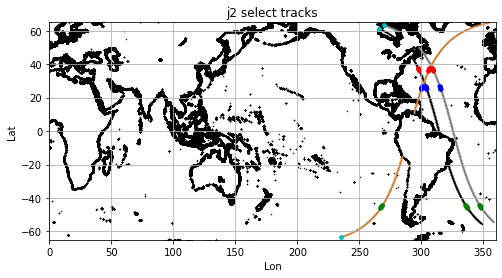

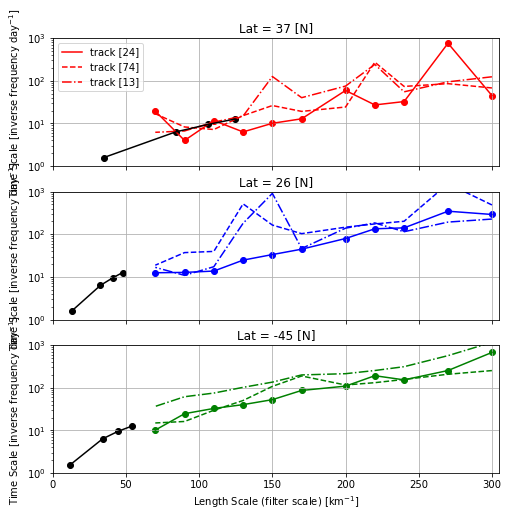

In [24]:
# EDDY SPACE-TIME PREDICTIONS 
t_i_1 = np.array([24])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
t_i_2 = np.array([74])
t_i_3 = np.array([13])
track_i_1 = np.where(track_record == t_i_1)[0][0]
track_i_2 = np.where(track_record == t_i_2)[0][0]
track_i_3 = np.where(track_record == t_i_3)[0][0]

x1 = 37
x2 = 26
x3 = -45
time_scale1 = np.nan * np.ones(len(coarsening_factors))
time_scale2 = np.nan * np.ones(len(coarsening_factors))
time_scale3 = np.nan * np.ones(len(coarsening_factors))
time_scale4 = np.nan * np.ones(len(coarsening_factors))
time_scale5 = np.nan * np.ones(len(coarsening_factors))
time_scale6 = np.nan * np.ones(len(coarsening_factors))
time_scale7 = np.nan * np.ones(len(coarsening_factors))
time_scale8 = np.nan * np.ones(len(coarsening_factors))
time_scale9 = np.nan * np.ones(len(coarsening_factors))
for i in tqdm(range(len(coarsening_factors))):
    x1_in = np.where((lat_record[track_i_1] > (x1 - 1)) & (lat_record[track_i_1] < (x1 + 1)))[0]
    x2_in = np.where((lat_record[track_i_1] > (x2 - 1)) & (lat_record[track_i_1] < (x2 + 1)))[0]
    x3_in = np.where((lat_record[track_i_1] > (x3 - 1)) & (lat_record[track_i_1] < (x3 + 1)))[0]   
    time_scale1[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x1_in]**2))/(60*60*24))/(2*np.pi)
    time_scale2[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x2_in]**2))/(60*60*24))/(2*np.pi)
    time_scale3[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x3_in]**2))/(60*60*24))/(2*np.pi)

    x1_in2 = np.where((lat_record[track_i_2] > (x1 - 1)) & (lat_record[track_i_2] < (x1 + 1)))[0]
    x2_in2 = np.where((lat_record[track_i_2] > (x2 - 1)) & (lat_record[track_i_2] < (x2 + 1)))[0]
    x3_in2 = np.where((lat_record[track_i_2] > (x3 - 1)) & (lat_record[track_i_2] < (x3 + 1)))[0] 
    time_scale4[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x1_in2]**2))/(60*60*24))/(2*np.pi)
    time_scale5[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x2_in2]**2))/(60*60*24))/(2*np.pi)
    time_scale6[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x3_in2]**2))/(60*60*24))/(2*np.pi)
    
    x1_in3 = np.where((lat_record[track_i_3] > (x1 - 1)) & (lat_record[track_i_3] < (x1 + 1)))[0]
    x2_in3 = np.where((lat_record[track_i_3] > (x2 - 1)) & (lat_record[track_i_3] < (x2 + 1)))[0]
    x3_in3 = np.where((lat_record[track_i_3] > (x3 - 1)) & (lat_record[track_i_3] < (x3 + 1)))[0] 
    time_scale7[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x1_in3]**2))/(60*60*24))/(2*np.pi)
    time_scale8[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x2_in3]**2))/(60*60*24))/(2*np.pi)
    time_scale9[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x3_in3]**2))/(60*60*24))/(2*np.pi)

space_scale1 = np.nan * np.ones(len(coarsening_factors_time))
space_scale2 = np.nan * np.ones(len(coarsening_factors_time))
space_scale3 = np.nan * np.ones(len(coarsening_factors_time))
for i in range(len(coarsening_factors_time)):
    # lat indices (on track 2)
    x1_ins = np.where((lat_record[track_i_1] > (x1 - 1)) & (lat_record[track_i_1] < (x1 + 1)))[0]
    x1_in2s = np.where((lat_record[track_i_1] > (x2 - 1)) & (lat_record[track_i_1] < (x2 + 1)))[0]
    x1_in3s = np.where((lat_record[track_i_1] > (x3 - 1)) & (lat_record[track_i_1] < (x3 + 1)))[0]
    space_scale1[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_ins]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    space_scale2[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_in2s]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    space_scale3[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_in3s]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    
f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[track_i_1], lat_record[track_i_1], s=0.1, color='k')
ax.scatter(lon_record[track_i_1][0], lat_record[track_i_1][0], s=15, color='c')
ax.scatter(lon_record[track_i_1][x1_in], lat_record[track_i_1][x1_in], s=8, color='r')
ax.scatter(lon_record[track_i_1][x2_in], lat_record[track_i_1][x2_in], s=8, color='b')
ax.scatter(lon_record[track_i_1][x3_in], lat_record[track_i_1][x3_in], s=8, color='g')
ax.scatter(lon_record[track_i_2], lat_record[track_i_2], s=0.1, color='#808080')
ax.scatter(lon_record[track_i_2][0], lat_record[track_i_2][0], s=15, color='c')
ax.scatter(lon_record[track_i_2][x1_in2], lat_record[track_i_2][x1_in2], s=8, color='r')
ax.scatter(lon_record[track_i_2][x2_in2], lat_record[track_i_2][x2_in2], s=8, color='b')
ax.scatter(lon_record[track_i_2][x3_in2], lat_record[track_i_2][x3_in2], s=8, color='g')
ax.scatter(lon_record[track_i_3], lat_record[track_i_3], s=0.1, color='#CD853F')
ax.scatter(lon_record[track_i_3][0], lat_record[track_i_3][0], s=15, color='c')
ax.scatter(lon_record[track_i_3][x1_in3], lat_record[track_i_3][x1_in3], s=8, color='r')
ax.scatter(lon_record[track_i_3][x2_in3], lat_record[track_i_3][x2_in3], s=8, color='b')
ax.scatter(lon_record[track_i_3][x3_in3], lat_record[track_i_3][x3_in3], s=8, color='g')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title(this_sat + ' select tracks')
ax.grid()
plt.show()
f.savefig(this_sat + '_single_tracks_key', dpi=300)

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,8), sharex=True, sharey=True)
ax1.scatter(coarsening_factors*hor_grid_spacing, time_scale1, color='r')
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale1, color='r', label='track ' + str(t_i_1))
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale4, color='r', linestyle='--', label='track ' + str(t_i_2))
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale7, color='r', linestyle='-.', label='track ' + str(t_i_3))
ax1.scatter(space_scale1, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax1.plot(space_scale1, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax1.set_title('Lat = ' + str(x1) + ' [N]')

ax2.scatter(coarsening_factors*hor_grid_spacing, time_scale2, color='b')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale2, color='b')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale5, color='b', linestyle='--')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale8, color='b', linestyle='-.')
ax2.scatter(space_scale2, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax2.plot(space_scale2, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax2.set_title('Lat = ' + str(x2) + ' [N]')

ax3.scatter(coarsening_factors*hor_grid_spacing, time_scale3, color='g')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale3, color='g')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale6, color='g', linestyle='--')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale9, color='g', linestyle='-.')
ax3.scatter(space_scale3, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax3.plot(space_scale3, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax3.set_title('Lat = ' + str(x3) + ' [N]')
 
ax1.set_xlim([0, hor_grid_spacing*coarsening_factors[0]+5])
ax1.set_ylim([1, 1000])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_yscale('log')
ax3.set_xlabel('Length Scale (filter scale) [km$^{-1}$]')
ax1.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax2.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax3.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()
f.savefig(this_sat + '_single_tracks_l_t', dpi=300)

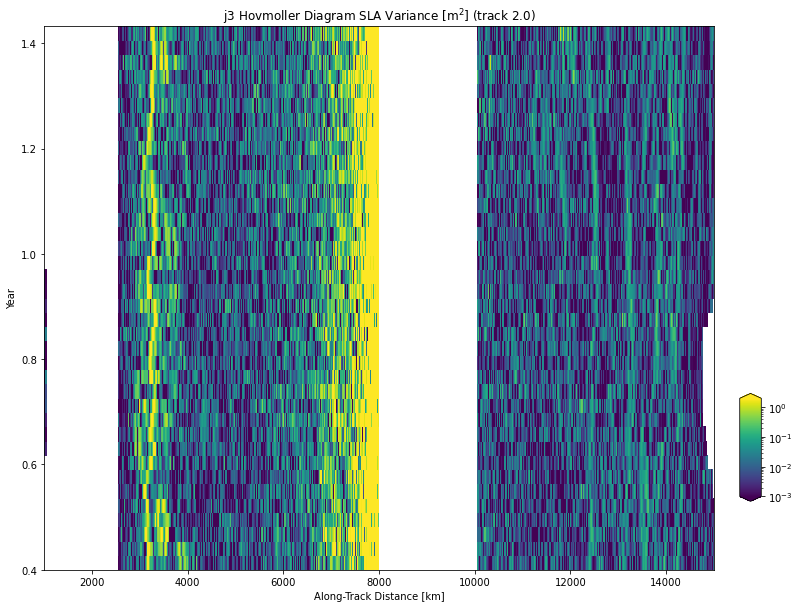

In [66]:
# -- TEMPORAL VARIABILITY
t_s = datetime.utcfromtimestamp(time_t_win[good_indi_dist][0])  # start time 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
offset = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365

levs = np.arange(0.001, 2, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 10))
axp = ax.pcolor(dist[gid], \
                ((time_t_win[gid] - time_t_win[gid][0])/(60*60*24))/365 + offset, \
                sla_t_win[gid]**2, \
                norm=LogNorm(vmin=levs[0], vmax=levs[-1])) #  vmin=-.75, vmax=.75)
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA Variance [m$^2$] (track ' + str(track_record[good_indi_dist]) + ')')
ax.set_xlim([1000, 15000])
cbpos = [0.93, 0.22, 0.025, 0.15]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
plt.show()
# f.savefig(this_sat + '_hovmoller', dpi=300)

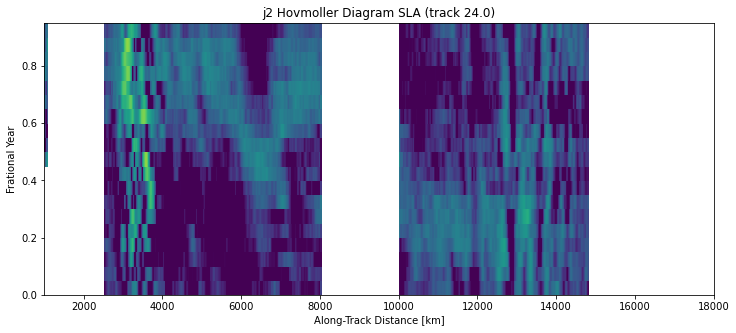

In [11]:
levs = np.arange(0.001, 0.5, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 5))
year_time_tot = ((time_t_win[good_indi_dist] - time_t_win[good_indi_dist][0])/(60*60*24))/365 + offset
year_time = np.mod(year_time_tot, 1)
t_step = np.arange(0, 1, 0.05)
sla_annual = np.nan * np.ones((len(t_step), np.shape(sla_t_win[good_indi_dist])[1]))
for i in range(len(t_step)-1):
    ii0 = t_step[i]
    ii1 = t_step[i+1]
    time_in = np.where((year_time > ii0) * (year_time < ii1))[0]
    sla_annual[i, :] = np.nanmean(sla_t_win[good_indi_dist][time_in, :], axis=0)
ax.pcolor(dist[good_indi_dist], t_step, sla_annual**2, norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Frational Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA (track ' + str(track_record[good_indi_dist]) + ')')
ax.set_xlim([1000, 18000])
plt.show()
# f.savefig(this_sat + '_hovmoller_2_annual', dpi=300)

In [10]:
# GLOBAL MAPS (gridding)
# bin variances 
step = 1
lon_win = 2.5
lat_win = 2.5
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 20
mean_sla = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_ets = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_els = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_sq_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth_deg = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_sq_smooth_deg = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c))) 
mean_v = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))               # velocity from adt
mean_v_anom = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # velocity anomaly (temporal)
mean_v_diff = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # EKE_1 (u - u_bar)**2
mean_v_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # EKE_2 (u**2 - u_bar**2)
mean_v_diff3 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # cross term (u_bar*u_prime) where u_prime = EKE_1
mean_v_diff3_gaussian = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
out_c = 0
for i in tqdm(range(len(lon_bins) - 1)):
    for j in range(len(lat_bins) - 1):
        # this_lon0 = lon_bins[i]
        # this_lon1 = lon_bins[i+1]
        # this_lat0 = lat_bins[j]
        # this_lat1 = lat_bins[j+1]
        
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                            (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                            (np.abs(lat_record[ai[tib]]) > 5))[0]
            # repeat for coarse grid 
            # inn2_coarse = np.where((lon_coarse[ai[tib]] > this_lon0) & (lon_coarse[ai[tib]] < this_lon1) & (lat_coarse[ai[tib]] > this_lat0) & (lat_coarse[ai[tib]] < this_lat1))[0]
            
            # -- find predicted length scale for time scale = coarsening_factors_time[m]
            # m = 2  # 60 days 
            # predicted_time_scale = np.nan*np.ones(len(coarsening_factors))
            # for k in range(len(coarsening_factors)):
            #     predicted_time_scale[k] = (np.nanmean(np.sqrt(((coarsening_factors[k]*hor_grid_spacing*1000)**2)/\
            #                                                   (vel_smooth_dict[k][ai[tib]][:, inn2]**2))/(60*60*24))/(2*np.pi)).flatten()
            # good = np.where(~np.isnan(predicted_time_scale))[0]
            # if len(good) > 2:
            #     l_at_t_m_from_l = np.interp(coarsening_factors_time[m]*repeat_time/(2*np.pi), \
            #                                 np.flip(predicted_time_scale[good]), np.flip(coarsening_factors[good])*hor_grid_spacing*1000)/1000 # in km 
            # else:
            #     l_at_t_m_from_l = np.nan
            # l_at_t_m_from_t = (np.nanmean(np.sqrt(((coarsening_factors_time[m]*repeat_time*(24*60*60))**2)*\
            #                                 (vel_time_smooth_dict[m][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten()  # in km 
            
            if count < 1:
                sla_i = sla_t_win[ai[tib]][:, inn2].flatten()
                # adt_i = adt[ai[tib]][:, inn2].flatten()
                # els_l = l_at_t_m_from_l  # length scale at t_m from spatially filtering to estimate time scale, then interpolate to t_m
                # els_t = l_at_t_m_from_t  # length scale at t_m from temporal filtering to estimate length scale 
                # ets_i = (np.nanmean(np.sqrt(((coarsening_factors[pick_spatial]*10*1000)**2)/(vel_smooth_dict[pick_spatial][ai[tib]][:, inn2]**2))/(60*60*24))).flatten()  # predicted time scale 
                # els_i = (np.nanmean(np.sqrt(((coarsening_factors_time[pick_temporal]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[pick_temporal][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten()
                # sla_smooth_i = sla_filt[ai[tib]][:, inn2].flatten()
                # sla_sq_smooth_i = sla_sq_smooth[ai[tib]][:, inn2].flatten()
                # sla_smooth_deg_i = sla_filtered_Ld[ai[tib]][:, inn2].flatten()
                # sla_sq_smooth_deg_i = sla_sq_filtered_deg[ai[tib]][:, inn2].flatten()
                # adt_smooth_i = adt_smooth[ai[tib]][:, inn2].flatten()
                # adt_coarse_i = adt_coarse[ai[tib]][:, inn2_coarse].flatten()         # adt coarse
                vel_i = total_vel[ai[tib]][:, inn2].flatten()                    # velocity from raw sla
                # vel_i_anom = (total_vel[ai[tib]][:, inn2]**2 - np.nanmean(total_vel[ai[tib]][:, inn2]**2, axis=0)).flatten() # velocity from raw sla
                # vel_smooth_i = vel_smooth_dict[-2][ai[tib]][:, inn2].flatten()             # velocity from smoothed raw velocity
                # vel_sq_smooth_i = total_vel_sq[ai[tib]][:, inn2].flatten() 
                # vel_smooth_g_i = vel_smooth_g_50[ai[tib]][:, inn2].flatten()
                
                count = count + 1
            else:
                sla_i = np.append(sla_i, sla_t_win[ai[tib]][:, inn2].flatten())
                # adt_i = np.append(adt_i, adt[ai[tib]][:, inn2].flatten())
                # els_l = np.append(els_l, l_at_t_m_from_l)
                # els_t = np.append(els_t, l_at_t_m_from_t)
                # ets_i = np.append(ets_i, (np.sqrt(((coarsening_factors[-1]*10*1000)**2)/(vel_smooth_dict[-1][ai[tib]][:, inn2]**2))/(60*60*24)).flatten())
                # els_i = np.append(els_i, (np.nanmean(np.sqrt(((coarsening_factors_time[0]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[0][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten())
                # sla_smooth_i = np.append(sla_smooth_i, sla_filt[ai[tib]][:, inn2].flatten())
                # sla_sq_smooth_i = np.append(sla_sq_smooth_i, sla_sq_smooth[ai[tib]][:, inn2].flatten())
                # sla_smooth_deg_i = np.append(sla_smooth_deg_i, sla_filtered_Ld[ai[tib]][:, inn2].flatten())
                # sla_sq_smooth_deg_i = np.append(sla_sq_smooth_deg_i, sla_sq_filtered_deg[ai[tib]][:, inn2].flatten())
                # adt_smooth_i = np.append(adt_smooth_i, adt_smooth[ai[tib]][:, inn2].flatten())
                # adt_coarse_i = np.append(adt_coarse_i, adt_coarse[ai[tib]][:, inn2_coarse].flatten())
                vel_i = np.append(vel_i, total_vel[ai[tib]][:, inn2].flatten())
                # vel_i_anom = np.append(vel_i_anom, (total_vel[ai[tib]][:, inn2]**2 - np.nanmean(total_vel[ai[tib]][:, inn2]**2, axis=0)).flatten()) 
                # vel_smooth_i = np.append(vel_smooth_i, vel_smooth_dict[-2][ai[tib]][:, inn2].flatten())
                # vel_sq_smooth_i = np.append(vel_sq_smooth_i, total_vel_sq[ai[tib]][:, inn2].flatten())
                # vel_smooth_g_i = np.append(vel_smooth_g_i, vel_smooth_g_50[ai[tib]][:, inn2].flatten())

        # save vel info 
        # if out_c < 1:
        #     cross_out = (vel_smooth_i*(vel_smooth_i - vel_i))
        #     bar_out = vel_smooth_i
        #     tot_out = vel_i
        #     out_c = 1
        # else:
        #     cross_out = np.append(cross_out, (vel_smooth_i*(vel_smooth_i - vel_i)))
        #     bar_out = np.append(bar_out, vel_smooth_i)
        #     tot_out = np.append(tot_out, vel_i)

        if (len(ai) > 1):
            if (len(sla_i) > thresh):
                mean_sla[i, j] = np.nanmean(sla_i**2)           # like a raw eddy energy estimate 
                # mean_adt[i, j] = np.nanmean(adt_i)              # raw adt
                # mean_ets[i, j] = np.nanmean(els_t)
                # mean_els[i, j] = np.nanmean(els_l)      # predicted length scale difference at t_m ()
                # mean_sla_smooth[i, j] = np.nanmean(sla_smooth_i**2)     # smooth sla
                # mean_sla_sq_smooth[i, j] = np.nanmean(sla_sq_smooth_i)     # smooth sla_sq
                # mean_sla_smooth_deg[i, j] = np.nanmean(sla_smooth_deg_i**2)     # smooth sla
                # mean_sla_sq_smooth_deg[i, j] = np.nanmean(sla_sq_smooth_deg_i)     # smooth sla
                # mean_adt_smooth[i, j] = np.nanmean(adt_coarse_i)     # smooth adt
                # mean_adt_coarse[i, j] = np.nanmean(adt_coarse_i)     # coarse adt
                # mean_diff1[i, j] = (np.nanmean(adt_i) - np.nanmean(adt_coarse_i))**2   # adt - smooth_adt (like an eddy energy estimate)  (np.nanmean((adt_i - adt_s_i)**2))
                # mean_diff1[i, j] = np.nanmean((sla_i**2 - sla_smooth_i**2))/np.nanmean(sla_i**2)   # adt - smooth_adt (like an eddy energy estimate)  
                # mean_diff2[i, j] = np.nanmean(np.abs((adt_i - adt_s_i)/adt_i))
                
                mean_v[i, j] = np.nanmean(vel_i**2)                                        # calculated from adt gradients 
                # mean_v_anom[i, j] = np.nanmean(vel_i_anom)                                 # temporal EKE def 
                # mean_v_diff[i, j] = np.nanmean(vel_sq_smooth_i - vel_smooth_i**2)          # calculated from coarse sla 
                # mean_v_diff2[i, j] = np.nanmean((vel_i - vel_smooth_i)**2)              # calculated from coarse sla 
                # mean_v_diff3[i, j] = np.nanmean((vel_smooth_i*(vel_smooth_i - vel_i)))     # u_bar*u_prime 
                # mean_v_diff3_gaussian[i, j] = np.nanmean((vel_smooth_g_i*(vel_smooth_g_i - vel_i)))  # u_bar*u_prime 
                # mean_slope[i, j] = np.nanmean(sloper)
                # mean_slope_smooth[i, j] = np.nanmean(sloper1)
        ai = 0

In [82]:
print(np.shape(mean_els))
lon_in_test = np.where((lon_bin_c > 298) & (lon_bin_c < 300))[0]
lat_in_test = np.where((lat_bin_c > 38) & (lat_bin_c < 40))[0]
print(mean_els[lon_in_test, lat_in_test])
print(mean_ets[lon_in_test, lat_in_test])
print(coarsening_factors_time[m]*repeat_time)

(144, 52)
[147.42084114]
[115.241363]
59.494781574341985


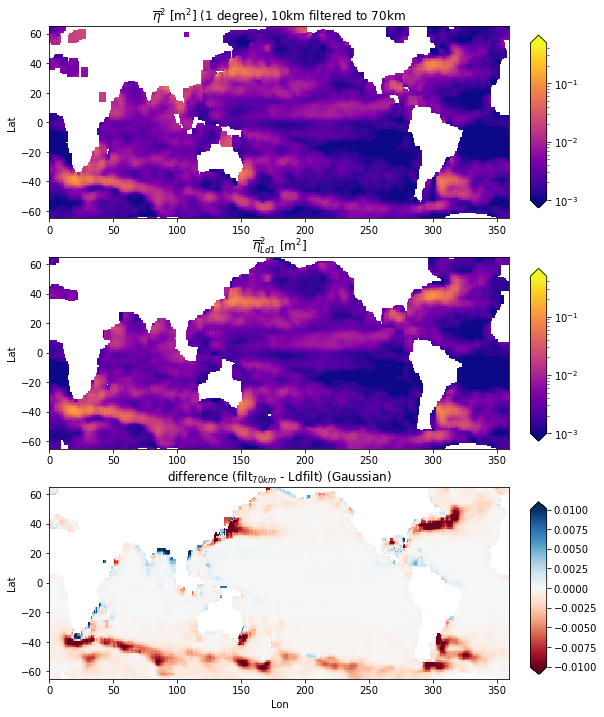

In [84]:
# SLA / ADT 
# x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/coastlines_global.nc')  
cmap0 = plt.get_cmap('plasma')
# cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
cbpos = [[0.9, 0.4, 0.025, 0.2], [0.9, 0.67, 0.025, 0.2], [0.9, 0.13, 0.025, 0.2]]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

levs = np.arange(0.001, 0.5, 0.01)
adt_lev = np.arange(-1, 2, 0.1)

# ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
# axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=plt.get_cmap('plasma'))
ax1.set_title(r'$\overline{\eta}^2$ [m$^2$] (' + str(step) + ' degree), ' + str(hor_grid_spacing) + 'km filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_ylabel('Lat')
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

# ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth_deg), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
# ax2.set_title(r'$\overline{\eta}^2$ [m$^2$] (' + str(step) + ' degree), ' + str(resolution) + '$^{\circ}$ filtered to ~' + str(sigma*resolution*2) + '$^{\circ}$')
ax2.set_title(r'$\overline{\eta}^2_{Ld1}$ [m$^2$]')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
ax2.set_ylabel('Lat')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

# ax3.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth - mean_sla_smooth_deg), vmin=-0.01, vmax=0.01, zorder=0, cmap=plt.get_cmap('RdBu'))
ax3.set_title('difference (filt$_{70km}$ - Ldfilt) (Gaussian)')
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=cmap0)
# ax3.set_title('$l_t - l_{l_{t=60days}}$ [m]', fontsize=14)
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
ax3.set_ylabel('Lat')
ax3.set_xlabel('Lon')
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
f.savefig(this_sat + '_fixed_vs_Ld_filt.jpg', dpi=400)

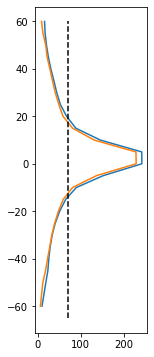

In [74]:
lat_ex = np.arange(-65, 65, 5)
mean_def = np.nan * np.ones(len(lat_ex))
mean_def2 = np.nan * np.ones(len(lat_ex))
for i in range(1, len(lat_ex)):
    mean_def[i] = np.nanmean(c98[(c98[:, 0] > lat_ex[i-1]) & (c98[:, 0] < lat_ex[i]) & \
                                 (c98[:, 1] > 150) & (c98[:, 1] < 275), 3])
    mean_def2[i] = np.nanmean(c98[(c98[:, 0] > lat_ex[i-1]) & (c98[:, 0] < lat_ex[i]) & \
                                 (c98[:, 1] > 300) & (c98[:, 1] < 360), 3])

f, ax = plt.subplots(1, 1, figsize=(2, 6))
ax.plot(mean_def, lat_ex)
ax.plot(mean_def2, lat_ex)
ax.plot(coarsening_factor0*hor_grid_spacing*np.ones(len(lat_ex)), lat_ex, color='k', linestyle='--')
plt.show()

NameError: name 'resolution' is not defined

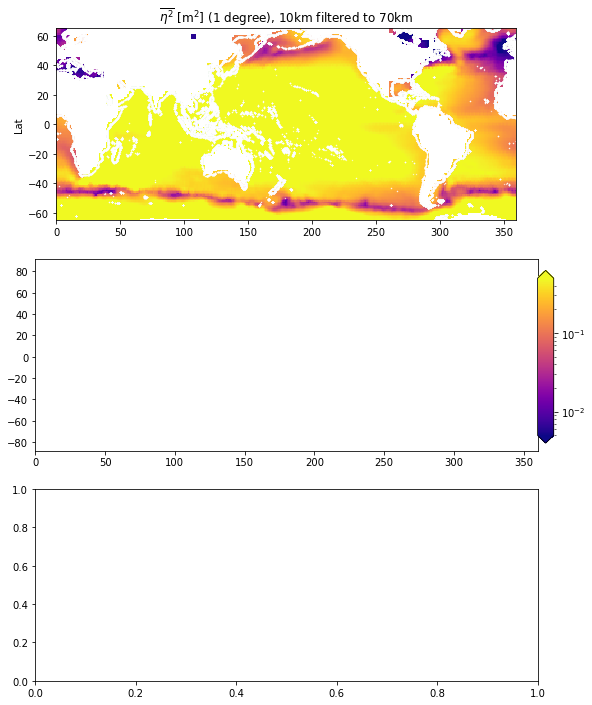

In [12]:
# SLA / ADT 
cmap0 = plt.get_cmap('plasma')
# cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
cbpos = [[0.9, 0.4, 0.025, 0.2], [0.9, 0.67, 0.025, 0.2], [0.9, 0.15, 0.025, 0.2]]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

levs = np.arange(0.005, 0.5, 0.01)
adt_lev = np.arange(-1, 2, 0.1)

ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
# axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=plt.get_cmap('plasma'))
ax1.set_title(r'$\overline{\eta^2}$ [m$^2$] (' + str(step) + ' degree), ' + str(hor_grid_spacing) + 'km filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_ylabel('Lat')
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth_deg), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
ax2.set_title(r'$\overline{\eta^2}$ [m$^2$] (' + str(step) + ' degree), ' + str(resolution) + '$^{\circ}$ filtered to ~' + str(sigma*resolution*2) + '$^{\circ}$')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
ax2.set_ylabel('Lat')
# ax2.set_title(r'mean ADT [m] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

ax3.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth - mean_sla_sq_smooth_deg), vmin=-0.005, vmax=0.005, zorder=0, cmap=plt.get_cmap('RdBu'))
ax3.set_title('difference (km - degree)')
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=cmap0)
# ax3.set_title('$l_t - l_{l_{t=60days}}$ [m]', fontsize=14)
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
ax3.set_ylabel('Lat')
ax3.set_xlabel('Lon')
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
# f.savefig(this_sat + '_fixed_vs_varying_l_total_var.jpg', dpi=400)

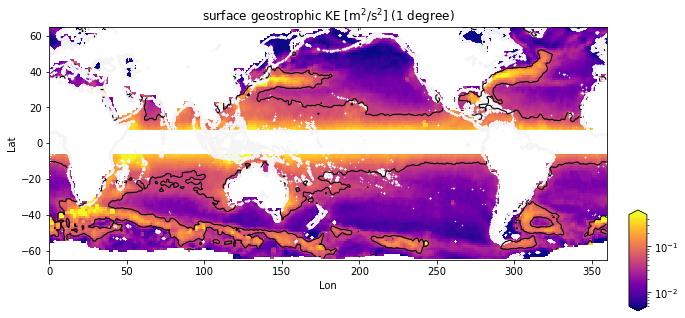

In [12]:
# --------------- fig 1
# plot, excluding equator 
v_in = np.where((lat_bin_c > -7.5) & (lat_bin_c < 7.5))[0]
# -- total KE 
mean_v_mask = mean_v.copy()
mean_v_mask[:, v_in] = np.nan
Lon_c, Lat_c = np.meshgrid(lon_bin_c, lat_bin_c)
Lon_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
Lat_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
save_f = 0 
# cbpos = [[0.19, 0.17, 0.2, 0.025], [0.62, 0.17, 0.2, 0.025]]
cbpos = [[0.93, 0.17, 0.025, 0.2], [0.62, 0.17, 0.2, 0.025]]

f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
levs = np.arange(0.005, 0.5, 0.01)
levs2 = [0.35]  
levs3 = [0.05]
levs4 = [0.025]
ax1.scatter(x4['lon'].values, x4['lat'].values, color='whitesmoke', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap='plasma')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=1.1, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'surface geostrophic KE [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

# ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v_mask_time), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.set_xlabel('Lon')
# ax2.set_title(r'Surface EKE$_{t}$ (u - $\left< u \right>$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax2.set_xlim([lon_w, lon_e])
# ax2.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_1.jpg', dpi=300)

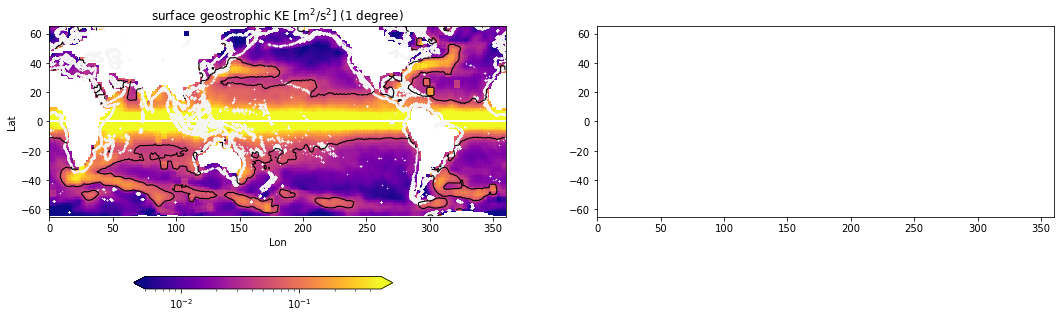

"\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))\n# EKE 1 \nax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)\naxp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v_tot_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))\n# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')\nax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')\n# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')\n# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')\n# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')\n# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidth

In [168]:
# sla velocity and adt velocity 
# -- EKE time
# mean_v_mask_time = mean_v_anom.copy()
# mean_v_mask_time[:, v_in] = np.nan
# -- EKE 1  (u^2_bar - u_bar^2)
# mean_v_tot_mask = mean_v_diff.copy()
# mean_v_tot_mask[:, v_in] = np.nan
# mean_v_tot_mask_negative_eke = np.transpose(mean_v_tot_mask.copy())
# -- EKE 2 (u_prime^2)
# mean_v_tot_mask2 = mean_v_diff2.copy()
# mean_v_tot_mask2[:, v_in] = np.nan
# mean_v_tot_mask2_negative_eke = np.transpose(mean_v_tot_mask2.copy())

# Lon_c, Lat_c = np.meshgrid(lon_bin_c, lat_bin_c)
# Lon_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
# Lat_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan

# # -- EKE cross term
# mean_v_tot_mask3 = mean_v_diff3.copy()
# mean_v_tot_mask3[:, v_in] = np.nan

save_f = 0 

# --------- fig 2 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# EKE 1 
ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v_tot_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax1.scatter(Lon_c.flatten(), Lat_c.flatten(), s=50, color='r')
ax1.set_xlabel('Lon')
ax1.set_title(r'Surface EKE$_1$ ($\overline{u_{90km}^2}$ - $\overline{u_{90km}}^2$) [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# EKE 2 
ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r'Surface EKE$_2$ (u - $\overline{u_{90km}}$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_2.jpg', dpi=300)

# --------- fig 3
# # levs2 = np.arange(0.035, 0.036, 0.01)
# levs_cross = np.arange(0.005, 0.5, 0.01)
# levs_frac = np.arange(-0.3, 0.35, 0.05)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
# # EKE 2 - EKE 1 (should equal the cross term)
# ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp2 = ax1.pcolor(lon_bins, lat_bins, np.transpose(np.abs(mean_v_tot_mask2 - mean_v_tot_mask)), norm=LogNorm(vmin=levs_cross[0], vmax=levs_cross[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# # axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(np.abs((mean_v_tot_mask2 - mean_v_tot_mask)/mean_v_tot_mask3)), vmin=1.75, vmax=2.25, zorder=0, cmap=plt.get_cmap('PiYG'))
# # ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.set_xlabel('Lon')
# ax1.set_title(r"Surface EKE$_2$ - EKE$_1$ = $\overline{\overline{u}u'}$ [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax1.set_xlim([lon_w, lon_e])
# ax1.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax1.set_aspect(w)
# cax = f.add_axes(cbpos[0])
# cb = f.colorbar(axp2, cax=cax, orientation='horizontal', extend='both')

# # cross term as a fraction
# ax2.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), vmin=levs_frac[0], vmax=levs_frac[-1], zorder=0, cmap=plt.get_cmap('PiYG'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), levels=levs_frac, zorder=1, linewidths=0.9, colors='k')
# ax2.set_xlabel('Lon')
# ax2.set_ylabel('Lat')
# ax2.set_title(r"$\overline{\overline{u}u'}$/KE [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax2.set_xlim([lon_w, lon_e])
# ax2.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# plt.show()
# if save_f:
#     f.savefig(this_sat + '_vel_eke_3.jpg', dpi=300)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


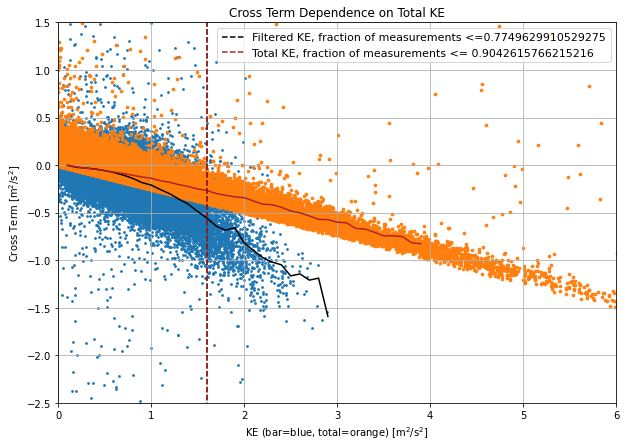

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [143]:
ke_bar = bar_out**2
ke_tot = tot_out**2
f, ax = plt.subplots(1, 1, figsize=(10,7))
ax.scatter(ke_bar, cross_out, s=3)
ax.scatter(ke_tot, cross_out, s=7)
ke_bin = np.arange(0, 4, 0.1)
ke_bin_c = ke_bin[0:-1] + np.diff(ke_bin)
ke_bar_mean = np.nan * np.ones(len(ke_bin_c))
ke_tot_mean = np.nan * np.ones(len(ke_bin_c))
bar_count = np.nan * np.ones((1, len(ke_bin_c)))
tot_count = np.nan * np.ones((1, len(ke_bin_c)))
for i in tqdm(range(len(ke_bin) - 1)):
    ke_bar_mean[i] = np.nanmean(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    ke_tot_mean[i] = np.nanmean(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
    bar_count[0, i] = len(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    tot_count[0, i] = len(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
ax.plot(ke_bin_c, ke_bar_mean, color='k', linewidth=1.5)
ax.plot(ke_bin_c, ke_tot_mean, color='firebrick', linewidth=1.5)
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='k', linestyle='--', label='Filtered KE, fraction of measurements <=' + str(np.nansum(bar_count[0, 0:15])/len(ke_bar)))
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='firebrick', linestyle='--', label='Total KE, fraction of measurements <= ' + str(np.nansum(tot_count[0, 0:15])/len(ke_tot)))
ax.set_xlabel(r'KE (bar=blue, total=orange) [m$^2$/s$^2$]')
ax.set_ylabel('Cross Term [m$^2$/s$^2$]')
ax.set_title('Cross Term Dependence on Total KE')
ax.set_xlim([0, 6])
ax.set_ylim([-2.5, 1.5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.grid()
plt.show()
f.savefig(this_sat + '_cross_terms.jpg', dpi=300)

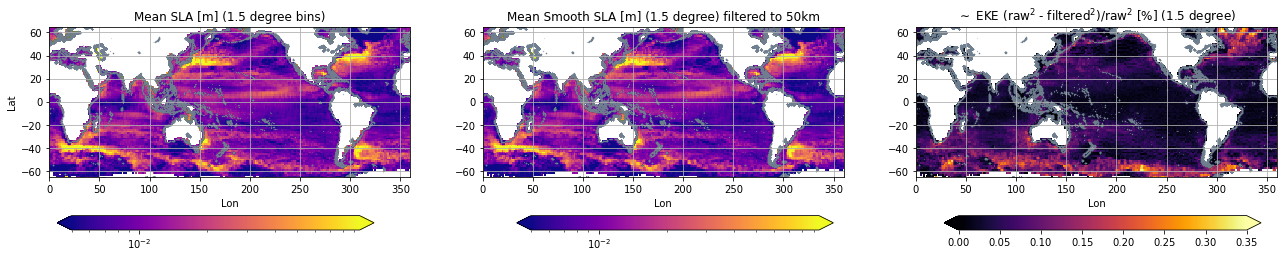

In [34]:
cbpos = [[0.13, 0.28, 0.2, 0.025], [0.42, 0.28, 0.2, 0.025], [0.69, 0.28, 0.2, 0.025]]
# cbpos = [[0.93, 0.68, 0.025, 0.2], [0.93, 0.4, 0.025, 0.2], [0.93, 0.15, 0.025, 0.2]]
# cbpos = [[0.19, 0.2, 0.2, 0.025], [0.62, 0.2, 0.2, 0.025]]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize = (22, 8))

# levs = np.arange(0.00001, 0.2, 0.01)
# lev = np.arange(0, 1, 0.1)
levs = np.arange(0.005, 0.1, 0.01)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))  # norm=LogNorm(vmin=levs[0], vmax=levs[-1])
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'Mean SLA [m] (' + str(step) + ' degree bins)')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax2.set_xlabel('Lon')
ax2.set_title(r'Mean Smooth SLA [m] (' + str(step) + ' degree) filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

# levs = np.arange(0.0000001, 0.001, 0.0001)
# levs = np.arange(0.001, 1, 0.001)
ax3.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1), vmin=-0, vmax=.35, zorder=0, cmap=plt.get_cmap('inferno'))  # np.abs((adt_i - adt_s_i)/adt_i)
ax3.set_xlabel('Lon')
ax3.set_title(r'$\sim$ EKE (raw$^2$ - filtered$^2$)/raw$^2$ [%] (' + str(step) + ' degree)')
# ax3.set_title(r'$\sim$ EKE |(raw - smoothed)/raw| [fraction] (' + str(step) + ' degree)')
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

f.savefig(this_sat + '_sla_map_50km_diff.jpg', dpi=400)

In [ ]:
# c98_f = open(r"/home/jovyan/along-track-altimetry-analysis/misc/global_deformation_radius_chelton_1998.txt",'r')  
# # http://www-po.coas.oregonstate.edu/research/po/research/rossby_radius/index.html#anchor2
# initial = c98_f.readlines()
# c98 = np.nan * np.ones((len(initial), 4))
# i = 0
# for line in initial:  # loops over each row
#     by_line = line.strip().split("\t")
#     by_item = by_line[0].split()
#     c98[i, :] = np.array([np.double(by_item[0]), np.double(by_item[1]), np.double(by_item[2]), np.double(by_item[3])])
#     i = i + 1
# file_out = '/home/jovyan/along-track-altimetry-analysis/misc/global_deformation_radius_chelton_1998.nc'
# if 1:     
#     OL_out = netCDF4.Dataset(file_out, 'w', format='NETCDF4_CLASSIC')
#     OL_out.title = 'http://www-po.coas.oregonstate.edu/research/po/research/rossby_radius/index.html#anchor2'
#     # create dimenision
#     dist_dim = OL_out.createDimension('list_dim', np.shape(c98)[0])
#     prof_num_dim = OL_out.createDimension('lat_lon_c_Ld', 4)
#     # assign variables   
#     data_out = OL_out.createVariable('values', np.float64, ('list_dim', 'lat_lon_c_Ld'))
#     data_out[:] = c98
#     OL_out.close() 

In [ ]:
# ---------------   
# -- export to nc (for testing with mspec)
# ---------------
# import netCDF4
# save_nc = 1
# if save_nc > 0:
#     OL_out = netCDF4.Dataset('test_out.nc', 'w', format='NETCDF4_CLASSIC')
#     # create dimenision
#     dist_dim = OL_out.createDimension('dist_dim', len(this_x))
#     prof_num_dim = OL_out.createDimension('cycle_dim', np.shape(this_sla)[0])
#     # assign variables
#     dist_out = OL_out.createVariable('dist_grid', np.float64, ('dist_dim'))
#     dist_out[:] = this_x   
#     u_out = OL_out.createVariable('sla', np.float64, ('cycle_dim', 'dist_dim'))
#     u_out[:] = this_sla
#     v_out = OL_out.createVariable('sla_smooth', np.float64, ('cycle_dim', 'dist_dim'))
#     v_out[:] = this_sla_smooth
#     OL_out.close() 

In [ ]:
# f, ax = plt.subplots(1, 1, figsize = (13, 7))
# for i in range(len(this_track)):
#     ax.scatter(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0, dist_by_track[this_track[i]][:, 1], s=0.2, label=time_log[this_track[i]])
# ax.set_xlabel('Along-Track Distance [km] (track=' + str(track_i) + ')')
# ax.set_ylabel('SLA [m]')
# ax.set_title('Sea Level Anomaly (2017)')
# # handles, labels = ax.get_legend_handles_labels()
# # ax.legend(handles, labels, fontsize=7)
# ax.grid()
# plt.show()

In [ ]:
# SHOULD NOW BE IN INITIAL PROCESSING NOTEBOOK 
# ------------------------------------------------------------------------------------------------
# RUN ONLY if parsed tracks file doesn't exist (should have a parsed file for each satellite)
# ------------------------------------------------------------------------------------------------
"""
# load individual sat (your choice) and convert to dataframe from dataset 
ds2_0 = cat[this_sat].to_dask()
%time ds2 = ds2_0[['latitude', 'longitude', 'sla_unfiltered', 'sla_filtered', 'track', 'cycle', 'mdt']].reset_coords().astype('f4').load()
%time df2 = ds2.to_dataframe()
df2_s = df2[(df2['longitude'] > lon_w) & (df2['longitude'] < lon_e) & (df2['latitude'] > lat_s) & (df2['latitude'] < lat_n)]
in_tracks2 = np.unique(df2_s['track'])
print('tracks in domain')
print(in_tracks2)

test = df2_s[df2_s['track'] == 11]  # 9 is standard
p = test.index
ts = (p - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
test2 = np.where(np.diff(ts) > 24*60*60)[0]
repeat_time = p[test2[3]] - p[test2[2]]
print('repeat time = ' + str(repeat_time))

test0 = df2_s[df2_s['track'] == in_tracks2[10]]  # 11
in_cycles0 = np.unique(test0['cycle'])
test1 = test0[test0['cycle'] == in_cycles0[0]]  # 20
ii = 5
d = Haversine(test1['latitude'][ii], test1['longitude'][ii], test1['latitude'][ii-1], test1['longitude'][ii-1])
print('nominal grid spacing = ' + str(d) + 'km')

# -- PARSE_grid_tracks (interpolate nans and group by track) (sla dimensions = [track_number][cycle, along_track_grid])
f_v_uf = 1  # if 1, use filtered product from aviso 
%time lon_t, lat_t, track_t, adt, sla, dist, lon_record, lat_record, time_record, track_record \
    = parse_grid_tracks(in_tracks2, df2_s, hor_grid_spacing, interp_cutoff, f_v_uf)

del sla # make more memory space 
# ---------------   
# -- export to pickle so that we don't have to run/parse everytime 
# ---------------
save_p = 1
if save_p > 0:
    outputs = {'lon_t': lon_t, 'lat_t': lat_t, 'track_t': track_t, 'adt': adt, \
               'dist': dist, 'lon_record': lon_record, 'lat_record': lat_record, \
               'time_record': time_record, 'track_record': track_record, \
               'repeat_time': repeat_time, 'interp_cutoff': interp_cutoff}
    pickle.dump(outputs, open(this_sat + '/' + this_sat + '_parsed_tracks_adt.p', 'wb'))
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# RUN AFTER parse_grid_tracks is completed  (should have a parsed file for each satellite)
# now interpolate in time (input should be output file from above cell)
# ------------------------------------------------------------------------------------------------
load_sat = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks_adt.p', 'rb'))
adt = load_sat['adt']
# -- interpolate in time 
interp_cutoff_t = 5  # time step to interpolate across (number samples, not a unit of time)
adt_time = []
sla_time = []
# - loop over tracks 
for i in tqdm(range(len(adt))):
    # - loop over along-track gridpoints 
    # this_interp_t_sla = np.nan * np.ones(np.shape(sla[i]))
    this_interp_t_adt = np.nan * np.ones(np.shape(adt[i]))
    for j in range(np.shape(adt[i])[1]): 
        # this_data_1 = sla[i][:, j]
        this_data_2 = adt[i][:, j]
        # if np.sum(np.isnan(this_data_1)) > 0:
        #     nans, x = nan_helper(this_data_1)
        #     this_interp_t_sla[:, j] = interp_nans(this_data_1, nans, x, interp_cutoff_t)
        # else:
        #     this_interp_t_sla[:, j] = this_data_1.copy()
        if np.sum(np.isnan(this_data_2)) > 0:
            nans, x = nan_helper(this_data_2)
            this_interp_t_adt[:, j] = interp_nans(this_data_2, nans, x, interp_cutoff_t)
        else:
            this_interp_t_adt[:, j] = this_data_2.copy()
    # sla_time.append(this_interp_t_sla)
    adt_time.append(this_interp_t_adt)
    
save_p = 1
if save_p > 0:
    outputs = {'adt': adt_time}
    pickle.dump(outputs, open(this_sat + '/' + this_sat + '_parsed_tracks_adt_interp_time_only.p', 'wb'))
"""

In [ ]:
"""
# --------------------------------------------------------------------
# CROSS-TRACK VELOCITY (from sla or adt)      
def velocity(dist, sla, lon_record, lat_record, track_record, stencil_width):   
    transition_lat = 5  # latitude to smoothly transition to beta-plane from local f-plane
    vel = []
    vel_f = []
    grad = []
    count = 0
    for m in tqdm(range(len(track_record))):
        # -- load in data for this track 
        this_sla = sla[m]            # interpolated field, sla is just a place holder (confusing I know)
        lon_grid = lon_record[m]
        lat_grid = lat_record[m]
        d_grid = dist[m]
        grid_space = d_grid[1] - d_grid[0]
        these_cycles = np.arange(0, np.shape(this_sla)[0])                 
        if len(d_grid) < 10:
            print('track ' + str(m) + ', too short') 
            grad.append(np.nan * np.ones(np.shape(this_sla)))
            vel.append(np.nan * np.ones(np.shape(this_sla)))
            continue
            
        # -- gradient (of interpolated field) (pol_rad = 6378.137km) (eq_rad = 6356.752km) 
        f_loc = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat_grid))    
        # estimate gradient from [Arbic 2012] 
        sla_grad = np.gradient(this_sla, d_grid*1000.0, axis=1)
        for cdm in range(4, 4 + len(sla_grad[0, 4:-3])):
            # -- gradients from a 7 point stencil 
            if stencil_width == 7:   
                sla_grad[:, cdm] = (this_sla[:, cdm+3] - 9*this_sla[:, cdm+2] + 45*this_sla[:, cdm+1] \
                                    - 45*this_sla[:, cdm-1] + 9*this_sla[:, cdm-2] - this_sla[:, cdm-3]) / (60*(grid_space*1000.0))   
            # -- gradients from a 5 point stencil
            elif stencil_width == 5:   
                sla_grad[:, cdm] = (-this_sla[:, cdm+2] + 8*this_sla[:, cdm+1] - 8*this_sla[:, cdm-1] \
                                    + this_sla[:, cdm-2]) / (12*(hor_grid_spacing*1000.0))
            elif stencil_width == 3: 
                sla_grad[:, cdm] = (this_sla[:, cdm+1] - this_sla[:, cdm-1]) / (2*(hor_grid_spacing*1000.0))  
            else:
                print('select either 3,5,7 for gradient stencil_width')
                
        # velocity via geostrophic balance 
        this_vel = (9.81/np.tile(f_loc[None, :], (len(these_cycles), 1))) * sla_grad 
        this_vel_f = this_vel.copy()
        
        # -- near equator attempt beta plane correction from [Lagerloef 1999] 
        # decide at what latitude to transition to beta plane 
        close_eq1 = np.where(np.abs(lat_grid) < transition_lat)[0]
        if len(close_eq1) > 10:  # if there are points close to equator, make sure there are enough to compute a gradient
            beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_grid[close_eq1]))/(6356752)
            y = 1852 * 60 * (lat_grid[close_eq1] - 0)  # 6356752*lat_grid[close_eq1]  
            # weights transitioning from beta plane to f plane 
            wb = np.exp(-(np.abs(lat_grid[close_eq1])/2.2)**2)
            wf = 1 - wb           
            # L = 111000, theta = y/L
            
            # approximate the along-track distance of d_eta/dx
            # d_sla_grad_dx = np.zeros(np.shape(sla_grad[:, close_eq1]))
            # d_sla_grad_dx[:, 1:-1] = (sla_grad[:, close_eq1[2:]] - sla_grad[:, close_eq1[0:-2]])/(y[2:] - y[0:-2])
            # ub = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * d_sla_grad_dx
            
            ub = (9.81/(y*np.tile(beta[None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]
            
            # uf = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_grad[:, close_eq1]
            # ub = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(sla_grad[:, close_eq1], y, axis=1)
            # uf_smooth = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_smooth_grad[:, close_eq1]
            # ub_smooth = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(adt_smooth_grad[:, close_eq1], y, axis=1)
            
            uf = (9.81/(np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]   # np.tile(1/theta[None, :], (len(these_cycles), 1))
            # ub1 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*y)) * adt_grad[:, close_eq1] # * np.tile(theta[None, :], (len(these_cycles), 1))
            # ub2 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**2, (len(these_cycles), 1))
            # ub3 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**3, (len(these_cycles), 1))
            # ub = ub1  # ub1 + ub2 + ub3
            
            ug = np.tile(wb[None, :], (len(these_cycles), 1))*ub + np.tile(wf[None, :], (len(these_cycles), 1))*uf
            this_vel[:, close_eq1] = ug 
            
            if m == 23:
                print(beta)
                print(lat_grid[close_eq1])
                # print(d_sla_grad_dx[5, :])
                print(ub[5, :])
                print(ug[5, :] - uf[5, :])
                print(ug[5, :])
        
        # -- save for each track arrays of fields [cycle X Distance] (each array is an element in a list)
        grad.append(sla_grad)
        vel.append(this_vel)
        vel_f.append(this_vel_f)
               
    return grad, vel, vel_f
"""